In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Load Data

In [3]:
# data_dir = "data"
data_dir = "data_new"

In [4]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 97860 files belonging to 2 classes.


In [5]:
data_iterator = data.as_numpy_iterator()
data_iterator

In [6]:
batch = data_iterator.next()

In [7]:
batch[1]

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1], dtype=int32)

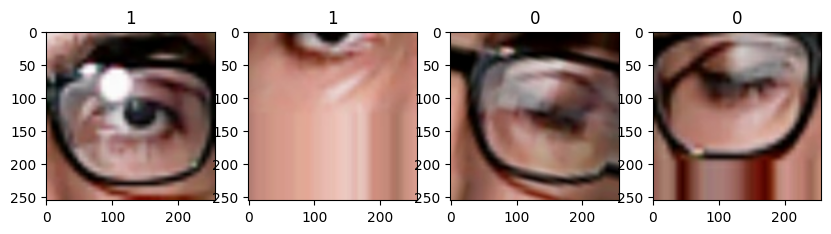

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for index, img in enumerate(batch[0][:4]):
    ax[index].imshow(img.astype(int))
    ax[index].set_title(batch[1][index])

### Convention:
- 1: Open Eyes 
- 0: Closed Eyes

### Scaling

In [9]:
data = data.map(lambda x,y: (x/255, y))

In [10]:
scaled_iterator = data.as_numpy_iterator().next()
scaled_iterator[0].min()

0.0

In [11]:
scaled_iterator[0][0].shape

(256, 256, 3)

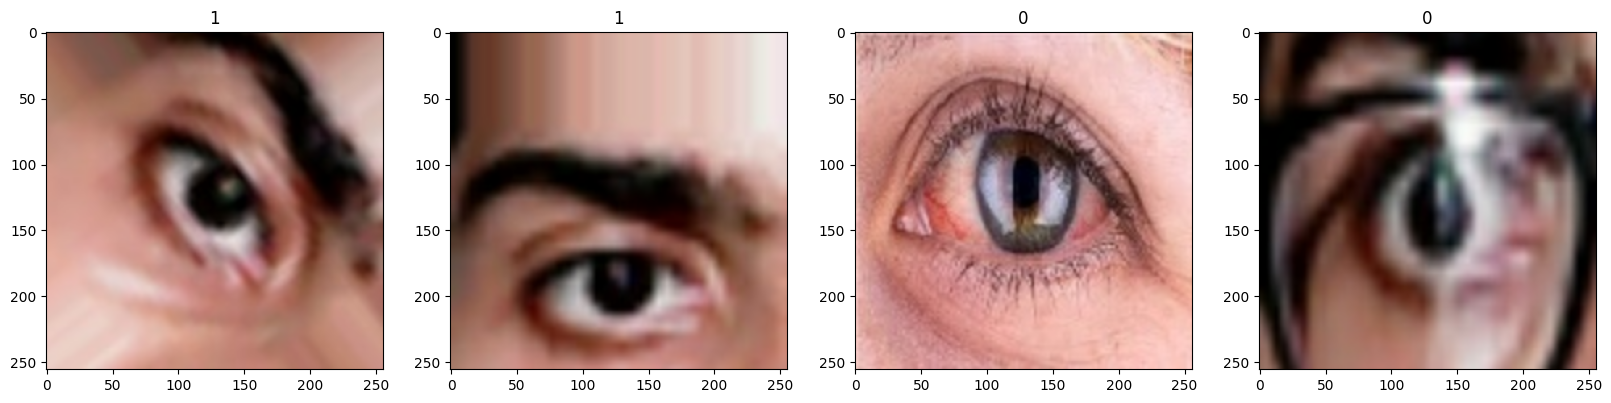

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for index, img in enumerate(scaled_iterator[0][:4]):
    ax[index].imshow(img)
    ax[index].title.set_text(batch[1][index])

### Data Splitting 

In [13]:
scale = 1

In [14]:
# Downsizing
data_size =len(data)*scale

train_size = int(0.7*data_size)
val_size = int(0.2*data_size)
test_size = int(0.1*data_size)
print(train_size, val_size, test_size, data_size)

2141 611 305 3059


In [15]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

### Building the Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [40]:
model=Sequential()

In [41]:
model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))


In [42]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)       

In [44]:
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [45]:
hist = model.fit(train_data, epochs=7, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/7


2141/2141 [==============================] - 868s 405ms/step - loss: 0.1084 - accuracy: 0.9590 - val_loss: 0.0330 - val_accuracy: 0.9876
Epoch 2/7
2141/2141 [==============================] - 861s 402ms/step - loss: 0.0339 - accuracy: 0.9885 - val_loss: 0.0336 - val_accuracy: 0.9892
Epoch 3/7
2141/2141 [==============================] - 889s 415ms/step - loss: 0.0231 - accuracy: 0.9921 - val_loss: 0.0227 - val_accuracy: 0.9917
Epoch 4/7
2141/2141 [==============================] - 885s 413ms/step - loss: 0.0170 - accuracy: 0.9939 - val_loss: 0.0191 - val_accuracy: 0.9934
Epoch 5/7
2141/2141 [==============================] - 895s 418ms/step - loss: 0.0139 - accuracy: 0.9954 - val_loss: 0.0218 - val_accuracy: 0.9927
Epoch 6/7
2141/2141 [==============================] - 904s 422ms/step - loss: 0.0118 - accuracy: 0.9959 - val_loss: 0.0352 - val_accuracy: 0.9909
Epoch 7/7
2141/2141 [==============================] - 878s 410ms/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.0214 - va

### Plotting Performance

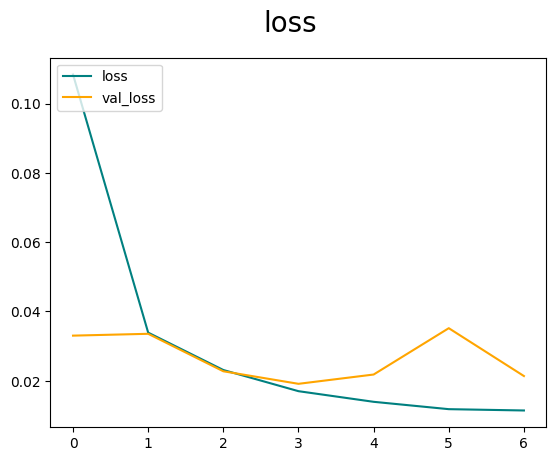

In [46]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val_loss")
plt.suptitle("loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Plotting Accuracy

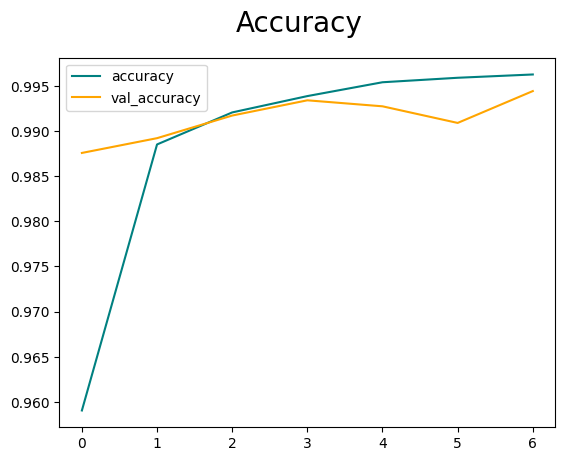

In [47]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="teal", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="orange", label="val_accuracy")
plt.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluating Performance

In [16]:
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy

In [17]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [18]:
model = tf.keras.models.load_model("./models/version-3")

In [19]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat=model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 96ms/step


In [20]:
print(f"Precision:{pre.result().numpy()} Recall:{re.result().numpy()} Accuracy:{acc.result().numpy()}")

Precision:0.9984139800071716 Recall:0.9940781593322754 Accuracy:0.9961065649986267


In [21]:
sample = test_data.as_numpy_iterator().next()

In [22]:
np.array(list(map(lambda x: 1 if x > 0.5 else 0, model.predict(sample[0]))))

1/1 [==============================] - 0s 107ms/step


array([0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0])

In [54]:
sample[0].shape

(32, 256, 256, 3)

# Saving the Model

In [55]:
model_version=4

In [56]:
model.save(f"models/version-{model_version}")

INFO:tensorflow:Assets written to: models/version-3/assets


INFO:tensorflow:Assets written to: models/version-3/assets
